# Analyse des données fournies par Assur'Aimant

Dans le but de réaliser une régression linéaire pour prédire "rapidement" une valeur de la colonne "charges",
analysons l'influence des valeurs de chaque autre colonne sur celle ci.

In [124]:
import pandas as pd
df = pd.read_csv("dataset.csv")
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [125]:
def get_region_code(region :str) -> int :
    match region : 
        case "northeast" : return 1 
        case "northwest" : return 2
        case "southwest" : return 3
        case "southeast" : return 4
        case _ : raise Exception("It should not happen")

dataframe_exploitable = df.copy()
dataframe_exploitable["sex"] = df["sex"].apply( lambda x : 1 if x == "male" else 0)
dataframe_exploitable["smoker"] = df["smoker"].apply( lambda x : 1 if x == "yes" else 0)
dataframe_exploitable["region"] = df["region"].apply( lambda x : get_region_code(x))
dfe = dataframe_exploitable
dfe.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.9240
1,18,1,33.77,1,0,4,1725.5523


# 1. Analyse univariée
D'abord chaque colonne séparément


## 1.1. Influence de l'age de l' assuré

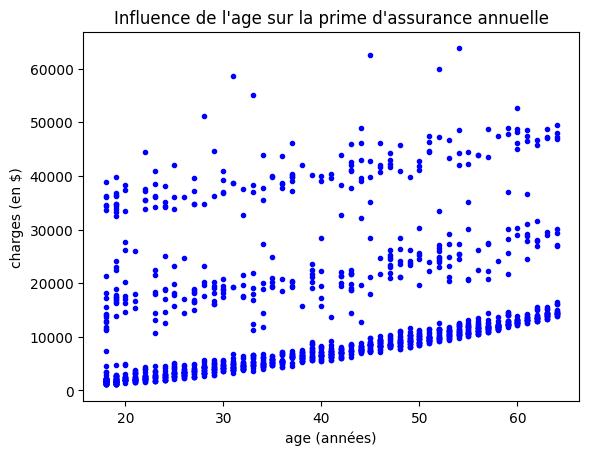

In [126]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(dfe, dtype=float)

#Colonne age
plt.xlabel("age (années)") # index = 0
plt.ylabel("charges (en $)") # index = 6
plt.plot(data[:,0], data[:,6], 'b.')
plt.title("Influence de l'age sur la prime d'assurance annuelle")
plt.show()

La prime d'assurance ( valeur de la colonne "charges") croit globalement avec l'age.

La relation ${charges} = f({age})$ semble linéaire : $${charges} = {A} \times {age} + {B} $$
ou peut être légèrement quadratique : $${charges} = {A} \times {age^2}  + {B} \times {age} + {C} $$


On peut donc choisir la colonne age comme un bon indicateur de base de la régression linéaire.

##  1.2. Influence du sexe de l'assuré

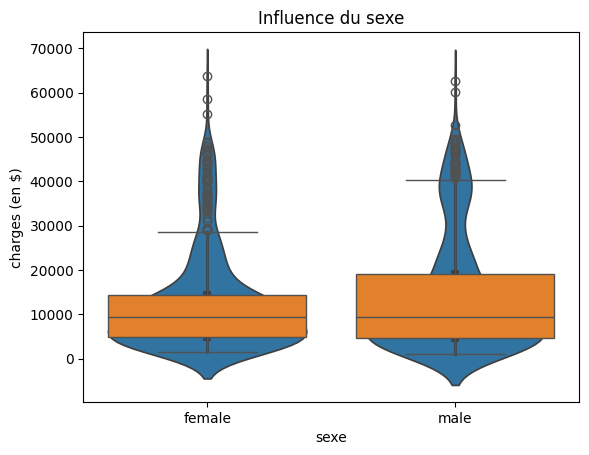

In [127]:
import seaborn as sns

#Colonne sex ( index = 1 )
sns.violinplot(x=df['sex'], y=df['charges']) 
sns.boxplot(x=df['sex'], y=df['charges']) 
plt.xlabel("sexe") # index = 1
plt.ylabel("charges (en $)") # index = 6
plt.title('Influence du sexe')
plt.show()

##  1.3. Influence de l'indice de masse corporelle

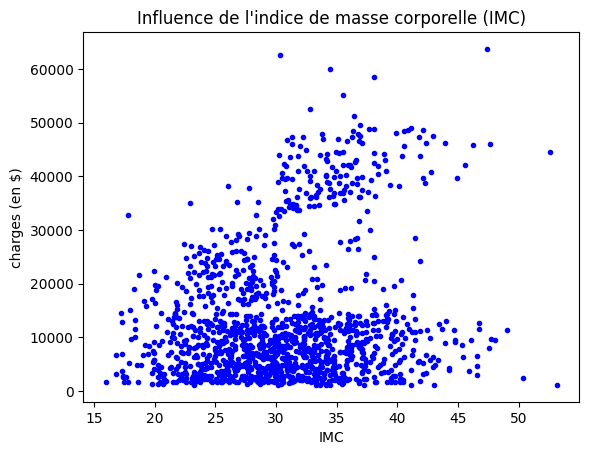

In [128]:
#Colonne bmi
plt.xlabel("IMC") # index = 2
plt.ylabel("charges (en $)") # index = 6

#sns.boxplot(x=df['bmi'], y=df['charges']) 
plt.plot(data[:,2], data[:,6], 'b.')
plt.title("Influence de l'indice de masse corporelle (IMC)")
plt.show()

Pas de relation évidente mais les données ne sont pas équilibrées : il existe une relation non triviale.

##  1.4. Influence du nombre d'enfants à charge

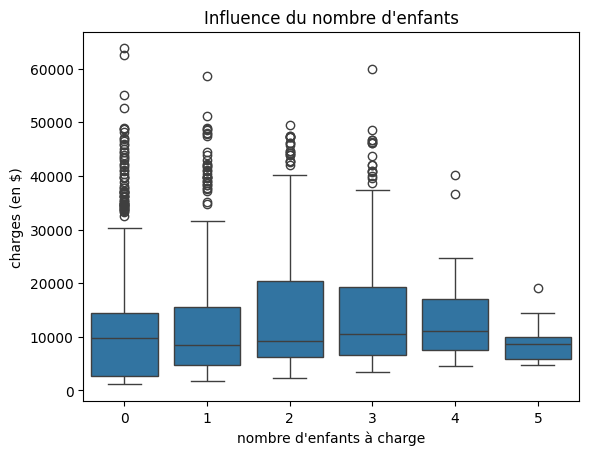

In [129]:
#Colonne children (index = 3)
plt.xlabel("nombre d'enfants à charge") # index = 3
plt.ylabel("charges (en $)") # index = 6
sns.boxplot(x=df['children'], y=df['charges'])
plt.title("Influence du nombre d'enfants")
plt.show()

Pas de relation évidente.

##  1.5. Influence du fait d'être fumeur

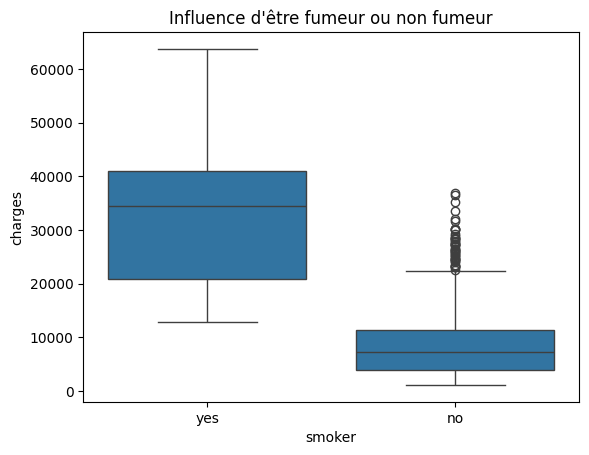

In [130]:
#Colonne smoker
sns.boxplot(x=df['smoker'], y=df['charges'])
plt.title("Influence d'être fumeur ou non fumeur")
plt.show()


Il y a clairement un lien : l'assuré paye beaucoup plus cher sa prime d'assurance quand il est fumeur.

## 1.6. Influence de la region

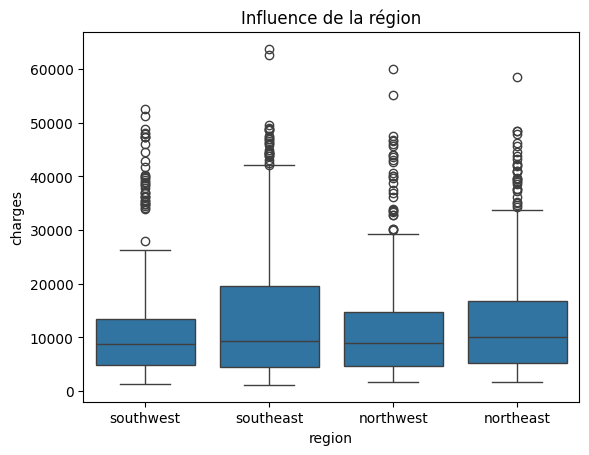

In [131]:
#Colonne region
sns.boxplot(x=df['region'], y=df['charges'])
plt.title("Influence de la région")
plt.show()

la médiane est proche, l'écart interquartile $Q_3 - Q_1$ est plus grand dans l'est.

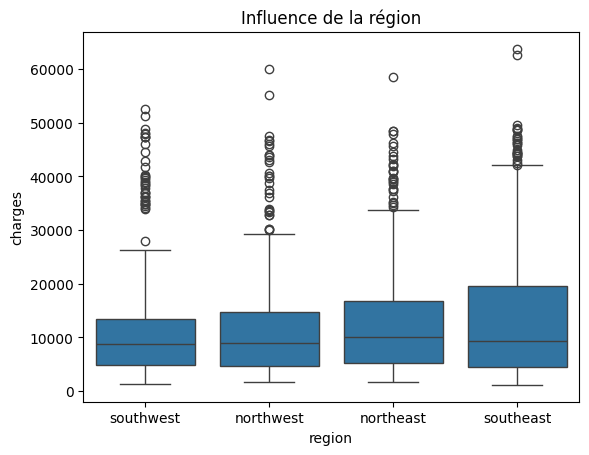

In [132]:
def numerize_region(region :str) -> int :
    match region : 
        case "southwest" : return 1
        case "northwest" : return 2
        case "northeast" : return 3
        case "southeast" : return 4
        case _ : raise Exception("It should not happen")

def replace_region(region :str) -> str :
    int_region = int(region)
    match int_region : 
        case 1 : return "southwest" 
        case 2 : return "northwest" 
        case 3 : return "northeast" 
        case 4 : return "southeast" 
        case _ : raise Exception("It should not happen")

df_reordered = pd.DataFrame(df)
df_reordered["region"] = df_reordered["region"].apply( lambda x : numerize_region(x))
df_reordered.sort_values( 'region', ascending=True, inplace=True)
df_reordered["region"] = df_reordered["region"].apply( lambda x : replace_region(x))

sns.boxplot(x=df_reordered['region'], y=df_reordered['charges'])
plt.title("Influence de la région")
plt.show()

Ce n'est pas un lien si évident que ça.

# 2. Analyse bivariée
Une première approche peut être d'afficher la matrice de corrélation (linéaire) des variables
    

In [133]:
correlation_matrix = dfe.corr()
correlation_matrix_without_diagonal = correlation_matrix.where(np.identity(correlation_matrix.shape[0]) != 1,0)

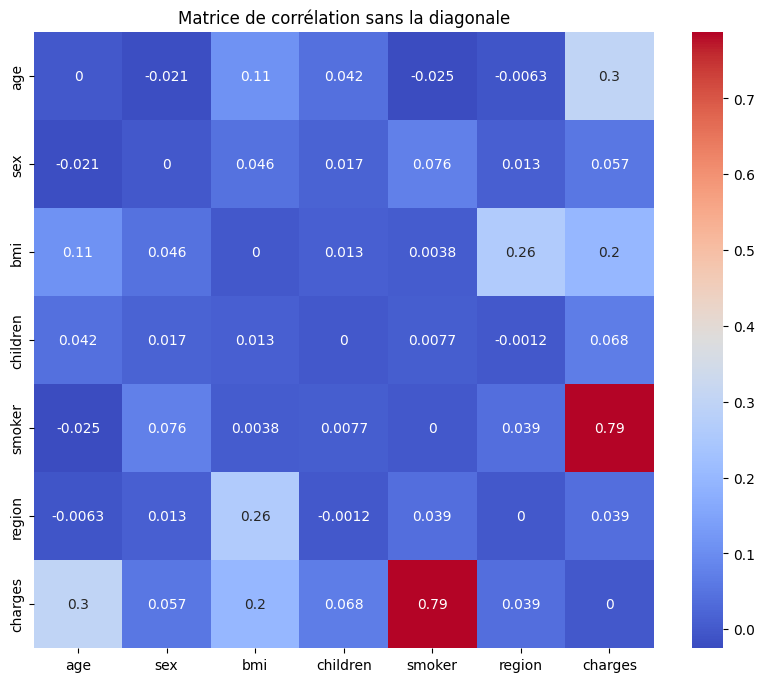

In [134]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_without_diagonal, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation sans la diagonale")
plt.show()

## 2.1. Relations linéaires avec la prime d'assurance
L'influence de chaque variable sur les charges apparait dans la dernière colonne et la dernière ligne.
- La prime d'assurance est fortement corrélée avec le fait d'être fumeur ( 0.79 )
- L'age est le second poste ( 0.30  )
- L'indice de masse corporelle (IMC, bmi) intervient en troisième position ( 0.20 )
- Le nombre d'enfants intervient de manière plus faible en quatrième ( 0.07 )
- En cinquième le sexe ( 0.06 )
- En dernier la région ( 0.04 )

## 2.2. Relations des variables entre elles

### 2.2.1 Relations croisées avec le fait dêtre fumeur
cinq croisements possibles : age, bmi children, sexe, region
#### 2.2.1.1 Relation smoker - age


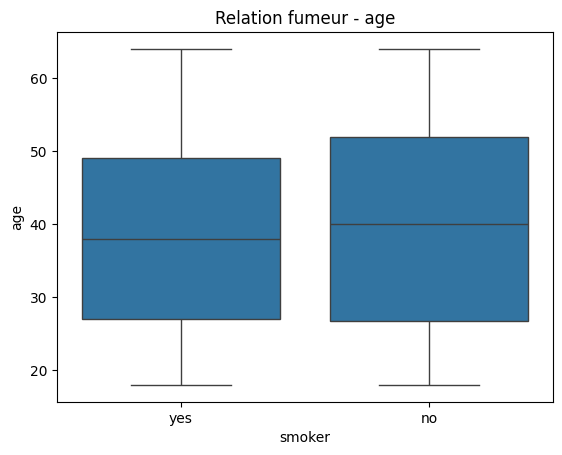

In [135]:
sns.boxplot(x=df['smoker'], y=df['age'])
plt.title("Relation fumeur - age")
plt.show()

La médiane des non fumeurs est plus élevée. Pas de surprise, les non fumeurs vivent plus longtemps.

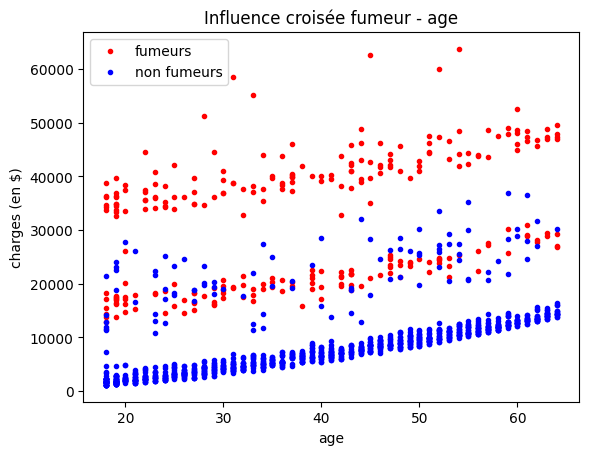

In [136]:
# Lien avec les charges :
data_S = np.array(df[df["smoker"]=="yes"]) 
data_N = np.array(df[df["smoker"]=="no"])

plt.xlabel("age") 
plt.ylabel("charges (en $)")
plt.plot(data_S[:, 0], data_S[:, 6], "r.", label="fumeurs") 
plt.plot(data_N[:, 0], data_N[:,6], "b.", label="non fumeurs") 
plt.title("Influence croisée fumeur - age")
plt.legend()
plt.show()

On distingue 3 parties distinctes sur lesquelles les individus sont placés.

Chaque partie peut se modéliser comme une droite d'équation ${charges} = f({age}) = {A} \times {age} + {B} $

Les trois droites semblent parallèles.

- Une droite basse (qui paye peu de charges) est constituée exclusivement de non fumeurs: 
$${charges_0} = {A} \times {age} + {B_0} $$ 
- Une droite médiane constituée de fumeurs et de non fumeurs : 
$${charges_1} = {A} \times {age} + {B_1} $$ 
- Une droite haute constituée exclusivement de fumeurs :  
$${charges_2} = {A} \times {age} + {B_2} $$  

Les deux variables smoker et age semblent assez bien modéliser les charges de manière linéaire.
il existe cependant une variable (probablement avec un seuil) non étudiée jusque là qui influence la valeur de la prime d'assurance charges

#### 2.2.1.2 Relation smoker - bmi


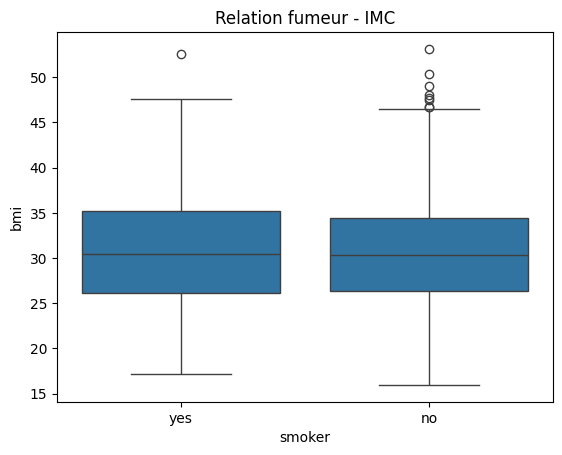

In [137]:
#Colonne smoker
sns.boxplot(x=df['smoker'], y=df['bmi'])
plt.title("Relation fumeur - IMC")
plt.show()

médiane et intervale interquartile similaires : Pas de corrélation entre smoker et bmi.

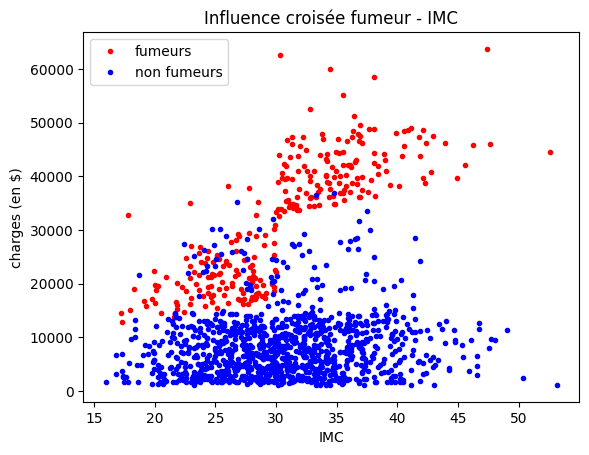

In [138]:
# Lien avec les charges :
data_S = np.array(df[df["smoker"]=="yes"]) 
data_N = np.array(df[df["smoker"]=="no"])

plt.xlabel("IMC") # index = 2
plt.ylabel("charges (en $)") # index = 6
plt.plot(data_S[:, 2], data_S[:, 6], "r.", label="fumeurs") # charges = f ( bmi )
plt.plot(data_N[:, 2], data_N[:,6], "b.",  label="non fumeurs") # charges = f ( bmi )
plt.title("Influence croisée fumeur - IMC")
plt.legend()
plt.show()


On distingue une différence nette entre les fumeurs (qui payent plus cher)  et les non fumeurs (qui payent moins cher).

Un seuil apparait pour les non fumeurs à la valeur IMC = 30.
les fumeurs dont l'IMC est supérieur à 30 payent significativement plus cher leur prime d'assurance.

In [139]:
# bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
# labels = ['insuffisant', 'normal', 'surpoids', 'obesite_g1', 'obesite_g2', 'obesite_g3']
# dfe['bmi_category'] = pd.cut(dfe['bmi'], bins=bins, labels=labels, right=False)

# plt.xlabel("IMC") # index = 2
# plt.ylabel("charges (en $)") # index = 6
# plt.hist(data_S[:, 6], "r.", label="fumeurs") # charges = f ( bmi )
# plt.hist(data_N[:,6], "b.",  label="non fumeurs") # charges = f ( bmi )
# plt.title("Influence croisée fumeur - IMC")
# plt.legend()
# plt.show()


#### 2.2.1.3 Relation smoker - children
#### 2.2.1.4 Relation smoker - sexe
#### 2.2.1.5 Relation smoker - region



### 2.2.2 Relations croisées avec l'age
quatre croisements restant possibles : bmi, children, sexe, region
#### 2.2.2.1 Relation age - bmi
#### 2.2.2.2 Relation age - children
#### 2.2.2.3 Relation age - sexe
#### 2.2.2.4 Relation age - region



### 2.2.3 Relations croisées avec l'IMC
trois croisements restant possibles : children, sexe, region
#### 2.2.3.1 Relation bmi - children
#### 2.2.3.2 Relation bmi - sex
#### 2.2.3.3 Relation bmi  region



### 2.2.4 Relations croisées avec le nombre d'enfants
deux croisements restant possibles : sexe, region
#### 2.2.4.1 Relation children - sex
#### 2.2.4.2 Relation children - region



### 2.2.5 Relations croisées avec le sexe
Un seul croisement n'a pas été traité : region
#### 2.2.5.1 Relation sex - region



## 2.3. Conclusion sur les relations